#### **Business Understanding**
Regression Analysis: Building Models to Predict Store Sales Using Time Series Forecasting

#### **Introduction**
Time series forecasting involves making scientific predictions by analyzing historical data with timestamps. This process entails constructing models through a detailed examination of past data, which are then utilized to make informed projections, guiding future strategic decision-making. It's important to recognize that during the forecasting process, the future outcome is entirely unknown and can only be approximated through meticulous analysis and evidence-based assumptions.

#### **Project Objective**
The primary goal of this project is to predict product unit sales across various stores, aiming to enhance inventory management, refine marketing strategies, and optimize pricing decisions for Favorita Corporation. To achieve this objective, we employ a combination of time series analysis and regression-based machine learning algorithms within the CRISP-DM framework.

This analysis seeks to identify the most effective prediction model from a diverse set of machine learning algorithms tested. The chosen model will be recommended to Favorita Corporation, providing valuable insights to facilitate informed decisions regarding retail sales, promotional activities, and customer satisfaction. By leveraging time series regression analysis, we aim to achieve a robust and reliable forecast of store sales, thereby supporting strategic planning and operational efficiency.



#### **Hypothesis Testing**

##### **Null Hypothesis:** The number of products under promotion does not influence sales of the company.

##### **Alternate Hypothesis:** The number of products under promotion significantly influence sales of the company..

#### **Analytical Question**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine
which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [239]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
import pyodbc
from dotenv import dotenv_values
import scipy.stats as stats
import warnings

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion


In [240]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.model_selection import cross_val_score, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr
import plotly as px
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss


# import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import random


warnings.filterwarnings('ignore')


In [241]:
from dotenv import dotenv_values
# import pyodbc

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('G:\python\python project\project\Time-Regression-Model\.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string = (
    f"DRIVER={{ODBC Driver 18 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=no;"
    f"Connection Timeout=200"
)

# Establish the connection
try:
    connection = pyodbc.connect(connection_string)
    print("Connection successful")
except pyodbc.Error as e:
    print(f"Error: {e}")


Connection successful


#### **Importations of All datasets that will be used Training Model**

In [242]:
# Query and load the data from dbo.oil
query = "SELECT * FROM dbo.oil"
df_oil= pd.read_sql(query, connection)
print("Data from dbo.oil:")

# Query and load the data from dbo.holidays_events
query = "SELECT * FROM dbo.holidays_events"
df_holiday = pd.read_sql(query, connection)
print("Data from dbo.holidays_events:")


# Query and load the data from dbo.stores
query = "SELECT * FROM dbo.stores"
df_stores = pd.read_sql(query, connection)
print("Data from dbo.stores:")

# Load train dataset
df_train=pd.read_csv(r"G:\python\python project\project\Time-Regression-Model\data\train.csv")

# load transaction dataset
df_transactions= pd.read_csv(r"G:\python\python project\project\Time-Regression-Model\data\transactions.csv")



Data from dbo.oil:
Data from dbo.holidays_events:
Data from dbo.stores:


In [243]:
#getting to know the data we are dealing with
print("-"*50)
print("First Five rows ","\n")
print(df_oil.head(5),"\n")

print("-"*50)
print("Shape of the Dataset","\n")
print(df_oil.shape, "\n")

print("-"*50)
print("Information About Dataset","\n")
df_oil.info()  # This will print the dataset information

print("-"*50)
print("Describe the Dataset","\n")
print(df_oil.describe().T, "\n")

print("-"*50)
print("Null Values ","\n")
print(df_oil.isnull().sum(),"\n")

print("-"*50)
print("Duplicated ","\n")
print(df_oil.duplicated().sum(),"\n")

print("-"*50)
print("Unique of the Dataset","\n")
print(df_oil.nunique(), "\n")


--------------------------------------------------
First Five rows  

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02   93.139999
2  2013-01-03   92.970001
3  2013-01-04   93.120003
4  2013-01-07   93.199997 

--------------------------------------------------
Shape of the Dataset 

(1218, 2) 

--------------------------------------------------
Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
--------------------------------------------------
Describe the Dataset 

             count       mean        std        min        25%        50%  \
dcoilwtico  1175.0  67.714366  25.630476  26.190001  46.405001  53.189999   

              75%         max  
dcoilwtico  95.66  110.

In [244]:
#getting to know the data we are dealing with
print("-"*50)
print("First Five rows ","\n")
print(df_holiday.head(5),"\n")

print("-"*50)
print("Shape of the Dataset","\n")
print(df_holiday.shape, "\n")

print("-"*50)
print("Information About Dataset","\n")
df_holiday.info()  # This will print the dataset information

print("-"*50)
print("Describe the Dataset","\n")
print(df_holiday.describe().T, "\n")

print("-"*50)
print("Null Values ","\n")
print(df_holiday.isnull().sum(),"\n")

print("-"*50)
print("Duplicated ","\n")
print(df_holiday.duplicated().sum(),"\n")

print("-"*50)
print("Unique of the Dataset","\n")
print(df_holiday.nunique(), "\n")

--------------------------------------------------
First Five rows  

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False   

--------------------------------------------------
Shape of the Dataset 

(350, 6) 

--------------------------------------------------
Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 

In [245]:
#getting to know the data we are dealing with
print("-"*50)
print("First Five rows ","\n")
print(df_stores.head(5),"\n")

print("-"*50)
print("Shape of the Dataset","\n")
print(df_stores.shape, "\n")

print("-"*50)
print("Information About Dataset","\n")
df_stores.info()  # This will print the dataset information

print("-"*50)
print("Describe the Dataset","\n")
print(df_stores.describe().T, "\n")

print("-"*50)
print("Null Values ","\n")
print(df_stores.isnull().sum(),"\n")

print("-"*50)
print("Duplicated ","\n")
print(df_stores.duplicated().sum(),"\n")

print("-"*50)
print("Unique of the Dataset","\n")
print(df_stores.nunique(), "\n")

--------------------------------------------------
First Five rows  

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4 

--------------------------------------------------
Shape of the Dataset 

(54, 5) 

--------------------------------------------------
Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-n

In [246]:
#getting to know the data we are dealing with
print("-"*50)
print("First Five rows ","\n")
print(df_train.head(5),"\n")

print("-"*50)
print("Shape of the Dataset","\n")
print(df_train.shape, "\n")

print("-"*50)
print("Information About Dataset","\n")
df_train.info()  # This will print the dataset information

print("-"*50)
print("Describe the Dataset","\n")
print(df_train.describe().T, "\n")

print("-"*50)
print("Null Values ","\n")
print(df_train.isnull().sum(),"\n")

print("-"*50)
print("Duplicated ","\n")
print(df_train.duplicated().sum(),"\n")

print("-"*50)
print("Unique of the Dataset","\n")
print(df_train.nunique(), "\n")

--------------------------------------------------
First Five rows  

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0 

--------------------------------------------------
Shape of the Dataset 

(3000888, 6) 

--------------------------------------------------
Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
----------

In [247]:
#getting to know the data we are dealing with
print("-"*50)
print("First Five rows ","\n")
print(df_transactions.head(5),"\n")

print("-"*50)
print("Shape of the Dataset","\n")
print(df_transactions.shape, "\n")

print("-"*50)
print("Information About Dataset","\n")
df_transactions.info()  # This will print the dataset information

print("-"*50)
print("Describe the Dataset","\n")
print(df_transactions.describe().T, "\n")

print("-"*50)
print("Null Values ","\n")
print(df_transactions.isnull().sum(),"\n")

print("-"*50)
print("Duplicated ","\n")
print(df_transactions.duplicated().sum(),"\n")

print("-"*50)
print("Unique of the Dataset","\n")
print(df_transactions.nunique(), "\n")

--------------------------------------------------
First Five rows  

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922 

--------------------------------------------------
Shape of the Dataset 

(83488, 3) 

--------------------------------------------------
Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
--------------------------------------------------
Describe the Dataset 

                count         mean         std  min     25%     50%     75%  \
store_n

#### **Insights or Observention**
* All datasets with date column need to be converted into datetime 
* All datasets have no duplicated values
* All datasets have no missing values except df_oil
* df_oil have 43 missing values which need to addressed using interpolate method

#### Convert date into datetime

#### **UNIQUE VALUES**

In [248]:
# Print first 20 unique values for each column in df_oil
print("Unique values in df_oil:")
for column in df_oil.columns:
    unique_values = df_oil[column].unique()
    print(f"\n{column}")
    print(f"There are {len(unique_values)} unique values")
    print(unique_values[:20])

# Print first 20 unique values for each column in df_holiday
print("\nUnique values in df_holiday:")
for column in df_holiday.columns:
    unique_values = df_holiday[column].unique()
    print(f"\n{column}")
    print(f"There are {len(unique_values)} unique values")
    print(unique_values[:20])
    
   
# Print first 54 unique values for each column in df_stores
print("Unique values in df_stores:")
for column in df_stores.columns:
    unique_values = df_stores[column].unique()
    print(f"\n{column}")
    print(f"There are {len(unique_values)} unique values")
    print(unique_values[:54])

# Print first 20 unique values for each column in df_train
print("Unique values in df_train:")
for column in df_train.columns:
    unique_values = df_train[column].unique()
    print(f"\n{column}")
    print(f"There are {len(unique_values)} unique values")
    print(unique_values[:20])

# Print first 20 unique values for each column in df_transactions
print("Unique values in df_transactions:")
for column in df_transactions.columns:
    unique_values = df_transactions[column].unique()
    print(f"\n{column}")
    print(f"There are {len(unique_values)} unique values")
    print(unique_values[:20])

Unique values in df_oil:

date
There are 1218 unique values
[datetime.date(2013, 1, 1) datetime.date(2013, 1, 2)
 datetime.date(2013, 1, 3) datetime.date(2013, 1, 4)
 datetime.date(2013, 1, 7) datetime.date(2013, 1, 8)
 datetime.date(2013, 1, 9) datetime.date(2013, 1, 10)
 datetime.date(2013, 1, 11) datetime.date(2013, 1, 14)
 datetime.date(2013, 1, 15) datetime.date(2013, 1, 16)
 datetime.date(2013, 1, 17) datetime.date(2013, 1, 18)
 datetime.date(2013, 1, 21) datetime.date(2013, 1, 22)
 datetime.date(2013, 1, 23) datetime.date(2013, 1, 24)
 datetime.date(2013, 1, 25) datetime.date(2013, 1, 28)]

dcoilwtico
There are 999 unique values
[        nan 93.13999939 92.97000122 93.12000275 93.19999695 93.20999908
 93.08000183 93.80999756 93.59999847 94.26999664 93.26000214 94.27999878
 95.48999786 95.61000061 96.08999634 95.05999756 95.34999847 95.15000153
 95.94999695 97.62000275]

Unique values in df_holiday:

date
There are 312 unique values
[datetime.date(2012, 3, 2) datetime.date(2012, 

#### **UNIVARIATE ANALYSIS**

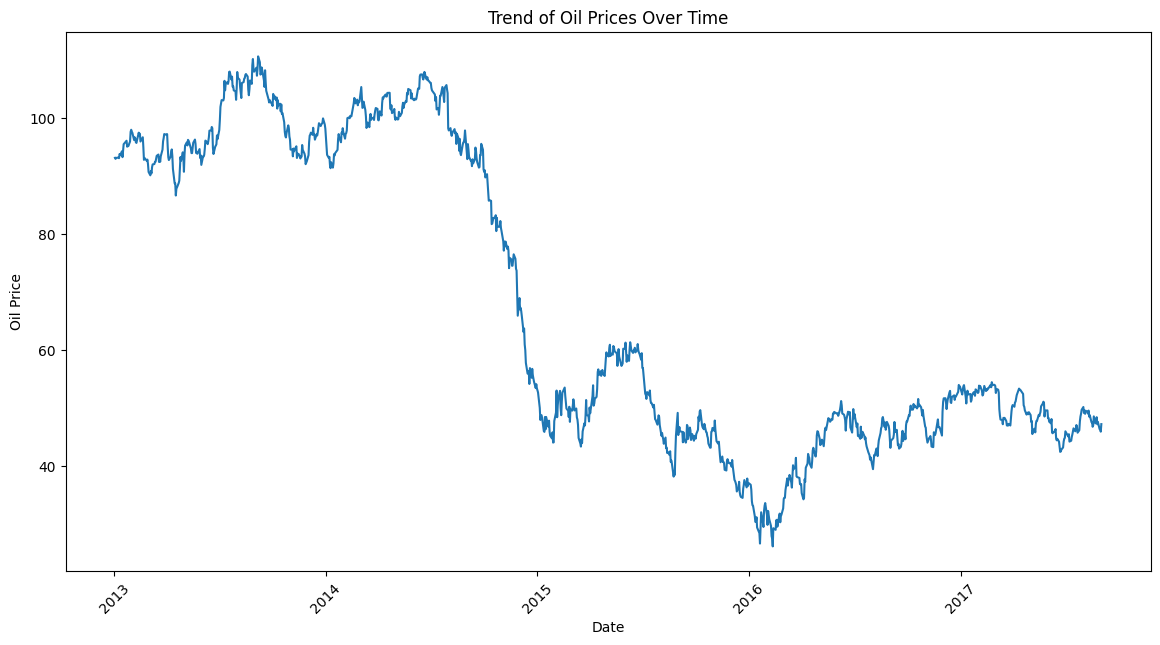

In [249]:

plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='dcoilwtico', data=df_oil)
plt.title('Trend of Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.show()

OBSERVATIONS
The trend reveals a decline in oil prices starting from 2015. This downward trajectory is further interrupted by noticeable disruptions, which are linked to the presence of missing or NaN values in the dataset. These gaps underscore the need for careful data cleaning to ensure an accurate and continuous analysis of the oil price trends.

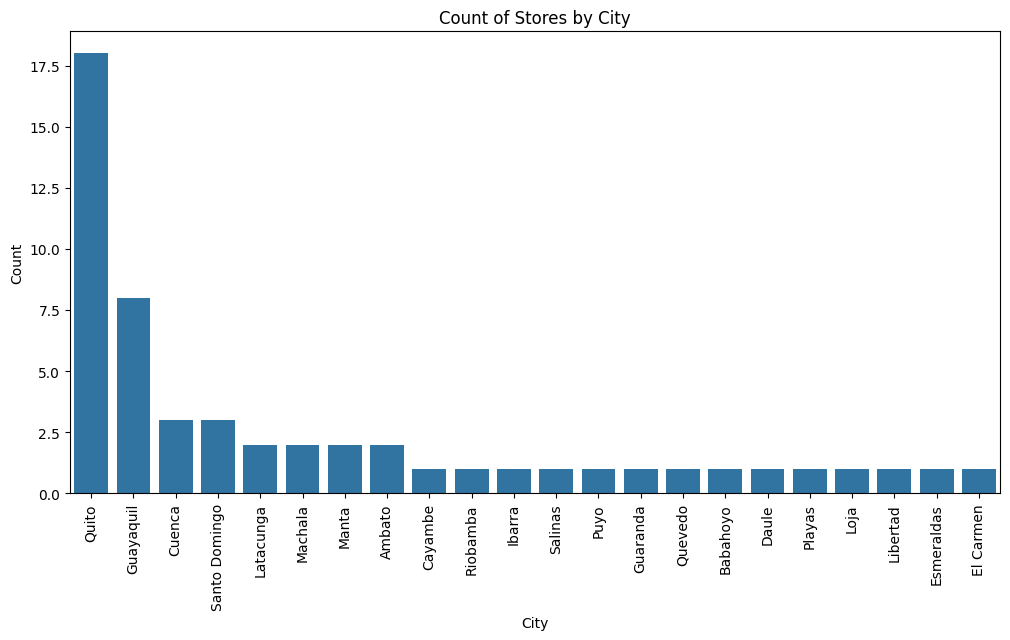

In [250]:
# Count of stores by city
plt.figure(figsize=(12, 6))
sns.countplot(x='city', data=df_stores, order=df_stores['city'].value_counts().index)
plt.title('Count of Stores by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

OBSERVATIONS
The visual representation reveals that Quito and Guayaquil have the highest number of stores compared to other cities, which typically maintain an average of one store each. This concentration of stores in Quito and Guayaquil highlights their significance as major retail hubs within the dataset.


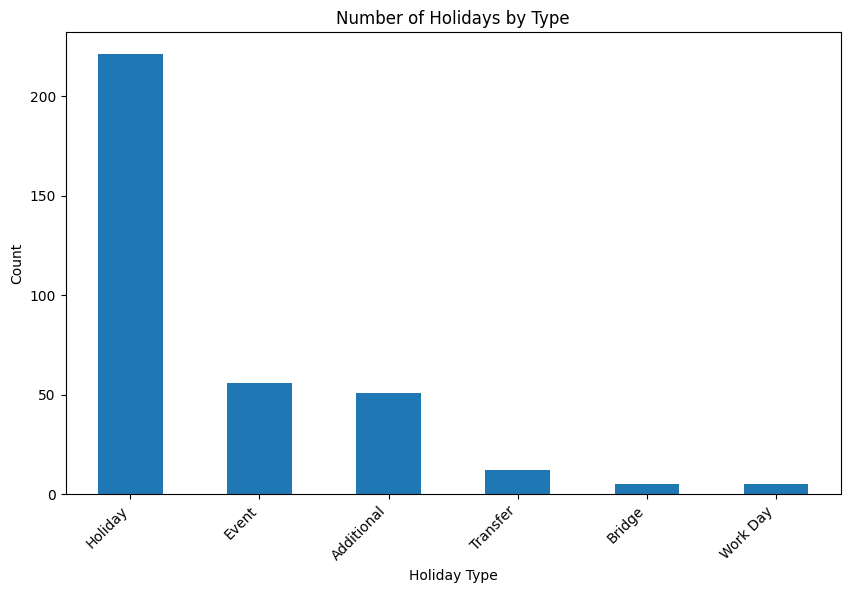

In [251]:
holiday_counts = df_holiday['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

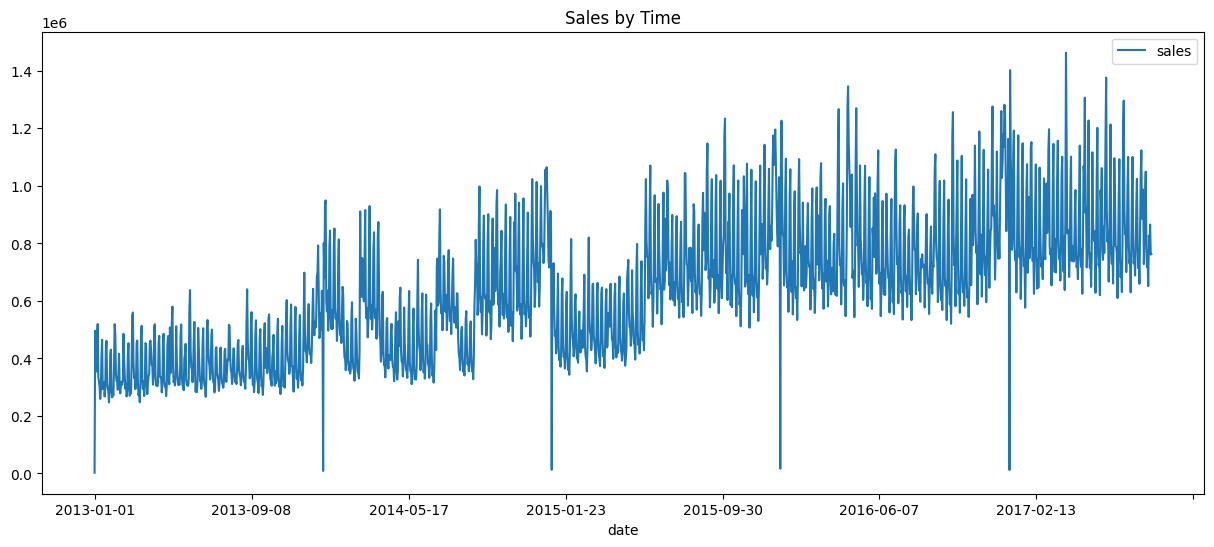

In [252]:
sales_trend = df_train.groupby('date').sales.sum().reset_index()    
sales_trend = sales_trend.set_index('date')

sales_trend.plot(figsize=(15, 6))
plt.title('Sales by Time')
plt.show()

OBSERVATIONS
The training data exhibits an upward trend overall, indicating increasing sales over time. However, it is noteworthy that there is a significant decline in sales at the beginning of each year. This recurring pattern suggests potential seasonal factors or market dynamics that negatively impact sales during this period.


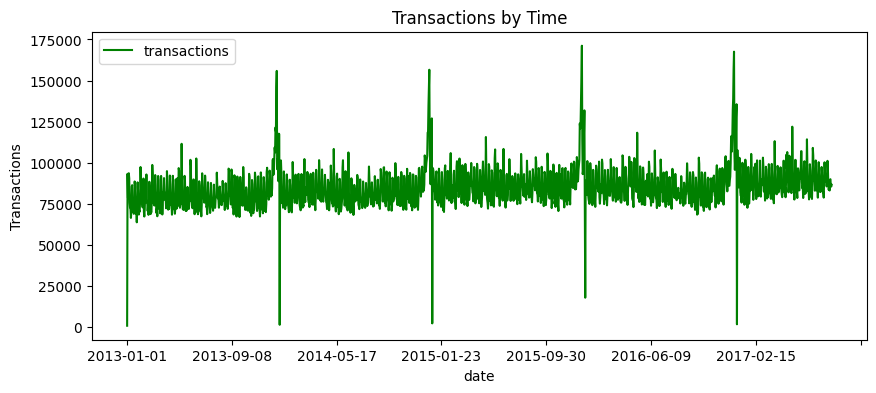

In [253]:
transaction_trends = df_transactions.groupby('date').transactions.sum().reset_index()
transaction_trends = transaction_trends.set_index('date')

transaction_trends.plot(figsize = (10,4), color= ('green'))
plt.title('Transactions by Time')
plt.ylabel('Transactions')
plt.show()

OBSERVATIONS
A detailed analysis reveals a consistent upward trend in yearly transactions, with 2016 emerging as the year with the highest sales records. Despite this overall growth, the month-to-month transaction levels remain relatively stable throughout the years. Notably, there are sharp increases in transactions during year-end periods, highlighting a distinct seasonal pattern in sales activity.

**Fill missing values in df_oil dataset**

In [254]:
df_oil["dcoilwtico"]= df_oil["dcoilwtico"].fillna(0)

In [255]:
df_oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

**Convert all date to datetimes**

In [256]:
df_oil["date"] = pd.to_datetime(df_oil["date"])
df_holiday["date"] = pd.to_datetime(df_holiday["date"])
df_train["date"] = pd.to_datetime(df_train["date"])
df_transactions["date"] = pd.to_datetime(df_transactions["date"])

#### **MERGING DATASETS**

In [257]:

# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df_merge = pd.merge(df_train, df_transactions, on=['date', 'store_nbr'], how='left')

# Merge holiday dataset to df_merge on 'date' column
df_merge = pd.merge(df_merge, df_holiday, on='date', how='left')

# Merge oil dataset to df_merge on 'date' column
df_merge = pd.merge(df_merge, df_oil, on='date', how='left')

# Merge store dataset to df_merge on 'store_nbr' column
df_merge = pd.merge(df_merge, df_stores, on='store_nbr', how='left')


In [258]:
df_merge.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False,0.0,Quito,Pichincha,D,13


In [259]:
# Rename the type_x and type_y
df_merge.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [260]:
df_merge.shape

(3054348, 17)

In [261]:
df_merge.shape

(3054348, 17)

In [262]:
df_merge.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
transactions     249117
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
dcoilwtico       878526
city                  0
state                 0
store_type            0
cluster               0
dtype: int64

In [263]:
df_merge[["transactions", "holiday_type", "locale_name", "description", "transferred", "dcoilwtico"]] = df_merge[["transactions", "holiday_type", "locale_name", "description", "transferred", "dcoilwtico"]].fillna("unknown")


#### Answer Hypothesis Test

Answer Analytical Question

1.Is the train dataset complete (has all the required dates)?

In [264]:
# Extract the 'onpromotion' and 'sales' columns
onpromotion = df_merge['onpromotion']
sales = df_merge['sales']

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = stats.pearsonr(onpromotion, sales)

# Define the significance level (alpha)
alpha = 0.05

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Check if the correlation is statistically significant
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant influence of onpromotion on sales.")
else:
    print("Fail to reject the null hypothesis. There is no significant influence of onpromotion on sales.")

Pearson Correlation Coefficient: 0.4282
P-value: 0.0000
Reject the null hypothesis. There is a significant influence of onpromotion on sales.


In [265]:
expected_dates = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max(), freq='D')
missing_dates = expected_dates[~expected_dates.isin(df_train['date'])]

if missing_dates.empty:
    print("The train dataset is complete.")
else:
    print("The train dataset is missing dates:")
    for date in missing_dates:
        print(date)

The train dataset is missing dates:
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


Observations
The absence of data on December 25th in the train dataset for the years 2013, 2014, 2015, and 2016 suggests that no sales transactions were recorded on these dates. This gap is likely due to the organization observing the Christmas holiday, leading to a cessation of business activities and data collection during this period. This pattern is consistent across different weekdays for each year: Wednesday in 2013, Thursday in 2014, Friday in 2015, and Sunday in 2016, reinforcing the conclusion that the missing data corresponds to the holiday observance.

2.Dates with highest and lowest Sales

Dates with the lowest sales for each year:
         year       date  sales
0        2013 2013-01-01    0.0
657558   2014 2014-01-01    0.0
1316898  2015 2015-01-01    0.0
1972674  2016 2016-01-01    0.0
2642706  2017 2017-01-01    0.0

Dates with the highest sales for each year:
         year       date       sales
569724   2013 2013-11-12   46271.000
1273284  2014 2014-12-08   45361.000
1941534  2015 2015-12-14   40351.460
2194017  2016 2016-05-02  124717.000
2806629  2017 2017-04-02   38422.625


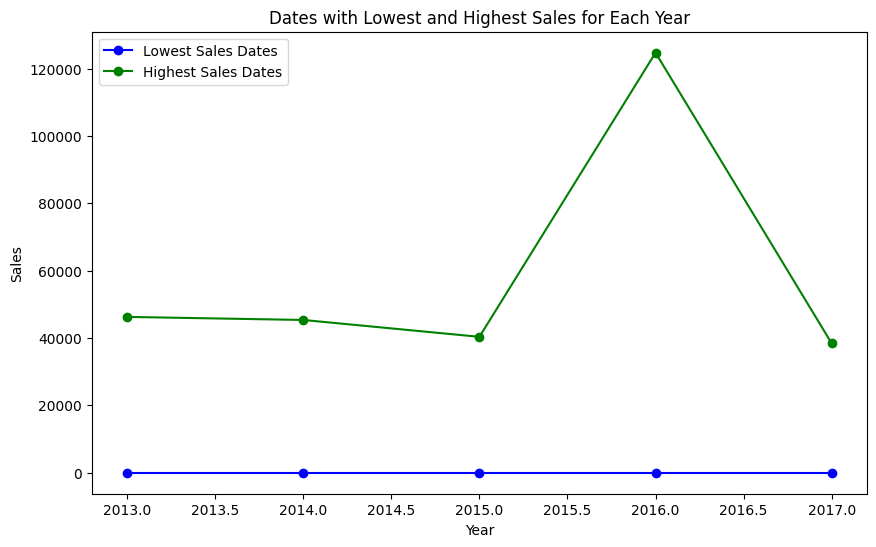

In [266]:
#train['date'] = pd.to_datetime(train_data['date'])
df_merge['year'] = df_merge['date'].dt.year
lowest_sales_dates = df_merge.loc[df_merge.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = df_merge.loc[df_merge.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates)
print("\nDates with the highest sales for each year:")
print(highest_sales_dates)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lowest_sales_dates['year'], lowest_sales_dates['sales'], color='blue', label='Lowest Sales Dates', marker='o')
ax.plot(highest_sales_dates['year'], highest_sales_dates['sales'], color='green', label='Highest Sales Dates', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Dates with Lowest and Highest Sales for Each Year')
ax.legend()
plt.show()

3.Impact of April 16, 2016 earthquake on sales.

In [267]:
# Set date as index
df_merge.set_index("date", inplace = True)

# Resample by week
weekly_sales = df_merge.resample("W")["sales"].sum()

# Date before the earthquake
before_earthquake = "2016-03-16"  
# Date of the earthquake
earthquake_date = "2016-04-16" 
# End date 
after_earthquake = "2016-05-16"

# Slice data before and after earthquake
sales_before_earthquake = weekly_sales.loc[before_earthquake:after_earthquake]
sales_after_earthquake = weekly_sales.loc[earthquake_date:after_earthquake]

fig, ax = plt.subplots(figsize = (10, 4))

# Plot before and after earthquake
ax.plot(sales_before_earthquake.index, sales_before_earthquake.values, marker = "o", color = "blue", label = "Before Earthquake")
ax.plot(sales_after_earthquake.index, sales_after_earthquake.values, marker = "o", color = "red", label = "After Earthquake")
ax.axvline(x = pd.to_datetime(earthquake_date), color = "k", linestyle= "--", label = f"Earthquake date: {earthquake_date}")

# Add labels
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Sales Before and After Earthquake")
ax.tick_params(axis = "x", labelrotation = 45)
ax.legend()
plt.show()

**Observations**

The earthquake on April 16th, 2016, did not appear to have a noticeable impact on sales. The chart above shows a consistent upward trend in sales from April 16th, 2016, to April 22nd, 2016. Despite the occurrence of the earthquake, sales continued to follow their established pattern, indicating that the event did not disrupt consumer purchasing behavior or retail operations significantly during this period. This resilience suggests that either the earthquake's impact was minimal on the retail sector, or that there were effective measures in place to maintain sales continuity.


5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
# Calculate total sales for the top 5 cities, clusters, states, and store types
top_cities = df_merge.groupby('city')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_clusters = df_merge.groupby('cluster')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_states = df_merge.groupby('state')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_store_types = train_eda.groupby('store_type')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Top 5 Sales by City, Cluster, State, and Store Type', fontsize=16)

# Add bar graphs for top cities
sns.barplot(data=top_cities, x='city', y='sales', ax=axes[0, 0])
axes[0, 0].set_title('Top Cities')
axes[0, 0].set_xlabel('City')
axes[0, 0].set_ylabel('Total Sales')

# Add bar graphs for top clusters
sns.barplot(data=top_clusters, x='cluster', y='sales', ax=axes[0, 1])
axes[0, 1].set_title('Top Clusters')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Total Sales')

# Add bar graphs for top states
sns.barplot(data=top_states, x='state', y='sales', ax=axes[1, 0])
axes[1, 0].set_title('Top States')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Total Sales')

# Add bar graphs for top store types
sns.barplot(data=top_store_types, x='store_type', y='sales', ax=axes[1, 1])
axes[1, 1].set_title('Top Store Types')
axes[1, 1].set_xlabel('Store Type')
axes[1, 1].set_ylabel('Total Sales')

# Adjust subplot layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

NameError: name 'train_eda' is not defined

In time series analysis, data is typically composed of four components: level (average value), trend (increasing or decreasing pattern), seasonality (repeating cycles), and noise (random variation). These components can be combined either additively or multiplicative.

In an additive model, the components are summed:

y(t) = Level + Trend + Seasonality + Noise

This model is linear and assumes consistent changes over time.

In a multiplicative model, the components are multiplied:

y(t) = Level * Trend * Seasonality * Noise

This model is nonlinear, allowing for changing patterns over time.

Decomposition helps structure time series anal, allowing you to address these components during data preparation and modeling. It can be implemented using the seasonal_decompose() method in the statsmodels library, specifying whether the model is additive or m

Seasonal Component:

The seasonal component represents the repeating patterns or fluctuations in your data that occur at regular intervals, typically within a year. These patterns can be due to various factors like seasons, holidays, or other regular events.
It has negative and positive values, indicating the magnitude and direction of the seasonal effect.
Seasonal values are typically constant for each corresponding time period (e.g., month) across multiple years.
Trend Component:

The trend component represents the long-term overall direction or trend in your data. It captures the gradual increase or decrease in the values over time.
It is usually represented by a linear or nonlinear function that reflects the underlying trend in the data.
Trend values can be positive or negative, depending on whether the data is increasing or decreasing over time.
Residual Component:

The residual component, also known as the error or noise, represents the part of the data that cannot be explained by the seasonal and trend components alone.
Residuals are typically the differences between the actual observed values and the values predicted by the seasonal and trend components.
They can be positive or negative and are often assumed to be random and normally distributed.

5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

6. Are sales affected by promotions, oil prices and holidays?

(a) Are sales affected by promotions


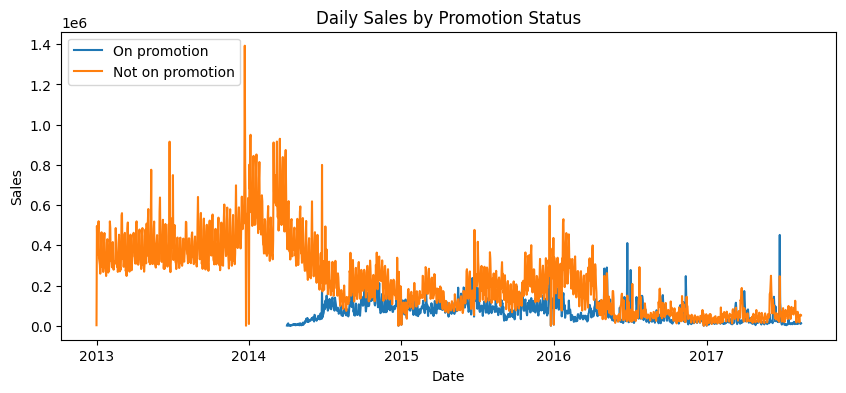

In [ ]:
# Convert 'date' column to datetime if it's not already
df_merge['date'] = pd.to_datetime(df_merge['date'])

# Set 'date' column as index
df_merge.set_index('date', inplace=True)

# Set figure size
plt.figure(figsize=(10, 4))

# Plot line chart for daily sales
plt.plot(df_merge[df_merge["onpromotion"] == 1].resample("D")["sales"].sum(), label="On promotion")
plt.plot(df_merge[df_merge["onpromotion"] == 0].resample("D")["sales"].sum(), label="Not on promotion")

# Set the title and labels
plt.title("Daily Sales by Promotion Status")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(loc="upper left")

# Display plot
plt.show()

(b) Are sales affected by oil prices

In [ ]:
# Fill null values in oil data
df_oil["dcoilwtico"] = df_oil["dcoilwtico"].interpolate()

# Merge train and oil dataframe 
train_oil_df = df_train.reset_index().merge(df_oil, how="left", on="date").set_index("date")

# drop null values from the combined oil and train dataframe
train_oil_df = train_oil_df.dropna()

# Calculate the correlation between sales and oil prices
corr, p_value = spearmanr(train_oil_df["sales"], train_oil_df["dcoilwtico"])
print("Spearman correlation: %.2f" % corr)
print("P-value: %.2f" % p_value)

Spearman correlation: -0.16
P-value: 0.00


observation

* The Spearman correlation coefficient of -0.16 indicates a weak negative relationship between sales and oil prices. This suggests that as oil prices increase, sales tend to decrease slightly, and vice versa. However, the strength of this relationship is quite weak.

* The p-value of 0.00 (or very close to zero) indicates that the correlation is statistically significant. In other words, we can reject the null hypothesis that there is no correlation between sales and oil prices at a significance levels of 0.05.

#### **Conclusion**
Despite the weak correlation, the statistically significant p-value suggests that changes in oil prices do have a small but reliable impact on sales. This weak negative correlation implies that other factors may also play a significant role in influencing sales, and oil prices alone do not explain much of the variation in sales.

(c) Are sales affected by holidays

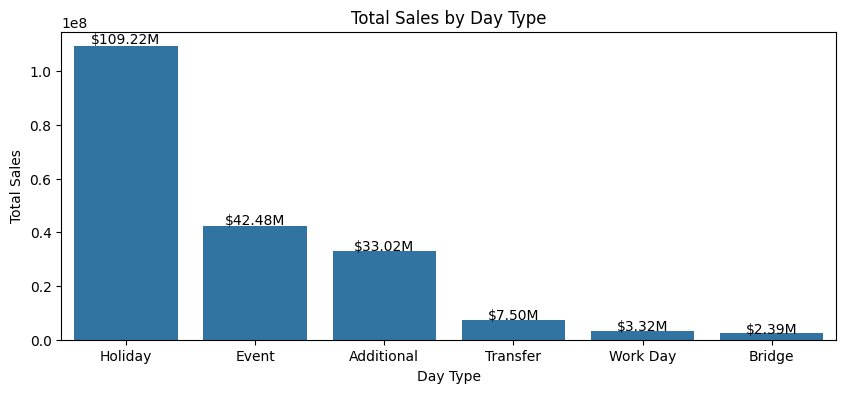

In [ ]:
# Merge train and holiday dataframe 
train_holiday_df = df_train.reset_index().merge(df_holiday, how = "left", on = "date").set_index("date")
train_holiday_df.dropna(inplace = True)

# Group data by day type
sales_day_type = train_holiday_df.groupby("type")["sales"].sum().sort_values(ascending = False)

# Plot bar chart
plt.figure(figsize = (10, 4))
sns.barplot(x = sales_day_type.index, y = sales_day_type.values)
plt.title("Total Sales by Day Type")
plt.xlabel("Day Type")
plt.ylabel("Total Sales")

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()

### Key Insights
- The bar for holidays shows the highest total sales, reaching approximately $109.22 million. This indicates that holidays significantly boost sales compared to other day types.

- Events and Additional days have substantial total sales of around $42.48 million and $33.02 million, respectively. This suggests that these day types are also associated with higher sales, albeit not as high as holidays.

- Transfer days, Work Days, and Bridge days have much lower total sales, with Transfer days at $7.50 million, Work Days at $3.32 million, and Bridge days at $2.39 million. This indicates that these day types do not contribute as significantly to total sales.

### Conclusion
The significant differences in total sales across different day types highlight that the nature of the day has a considerable impact on sales performance. Holidays have the most substantial impact on total sales, followed by Events and Additional days. Other day types such as Transfer, Work Days, and Bridge days contribute much less to overall sales. This suggests that special days, particularly holidays, are crucial for driving sales and should be a focal point in sales strategies and marketing efforts.



7. What analysis can we get from the date and its extractable features?

In [ ]:
# Duplicate "train_df"
train_dup_df = df_merge.copy(deep = True)
# Set date as index
train_dup_df.set_index("date", inplace = True)

# Group total sales by year
train_data_by_yr = train_dup_df.resample("Y")["sales"].sum()

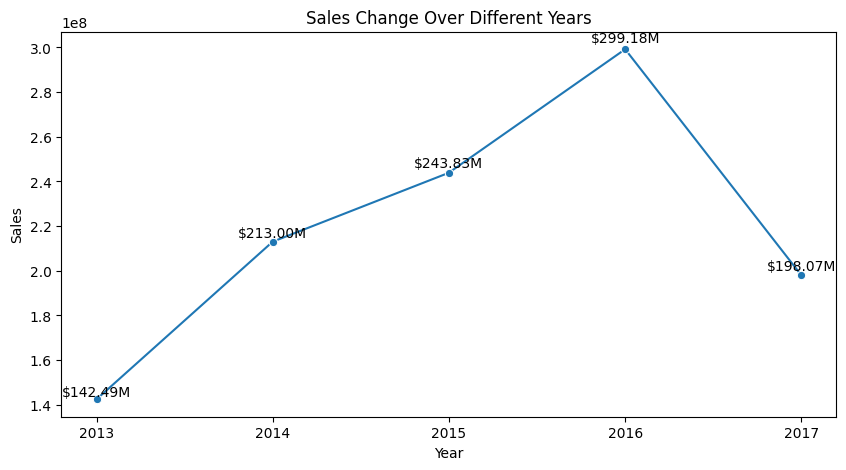

In [ ]:
# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.lineplot(x = train_data_by_yr.index, y = train_data_by_yr.values, marker = "o")

# Set the title and labels
plt.title("Sales Change Over Different Years")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(ticks = train_data_by_yr.index, labels = train_data_by_yr.index.year)

# Annotate points
for i, point in enumerate(plt.gca().get_lines()[0].get_xydata()):
    year, sales = point
    plt.annotate(f"${sales/10**6:,.2f}M", (year, sales*1.01), ha = "center")

### Key Insights
- The company experienced substantial growth in sales from 2013 to 2016, peaking in 2016, but faced a significant decline in 2017.
- Ecuador experienced economic growth during these years, particularly driven by high oil prices, which could have boosted consumer spending and sales.
- The 2016 Ecuador earthquake could have disrupted the economy, infrastructure, and consumer spending, with lingering effects into 2017

(b) Sales trend by quarter

In [ ]:
df_train.reset_index(inplace = True)
# Duplicate "train_df"
train_dup_df = df_train.copy(deep = True)
# Set date as index
train_dup_df.set_index("date", inplace = True)

In [ ]:
df_train.columns

Index(['level_0', 'index', 'date', 'id', 'store_nbr', 'family', 'sales',
       'onpromotion', 'year'],
      dtype='object')

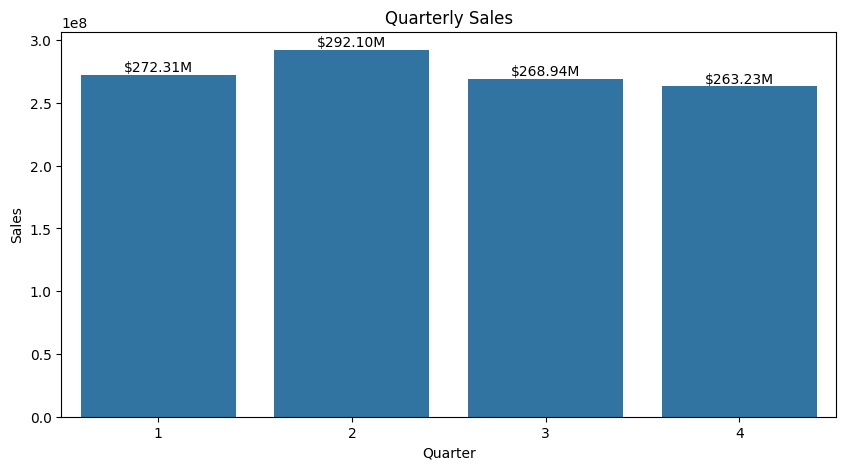

In [ ]:
# Add quarter column
df_merge["quarter"] = df_merge["date"].dt.quarter

# Group sales by quarter
qurtly_sales = df_merge.groupby("quarter")["sales"].sum()

# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.barplot(x = qurtly_sales.index, y = qurtly_sales.values)

# Set the title and labels
plt.title("Quarterly Sales")
plt.xlabel("Quarter")
plt.ylabel("Sales")

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()

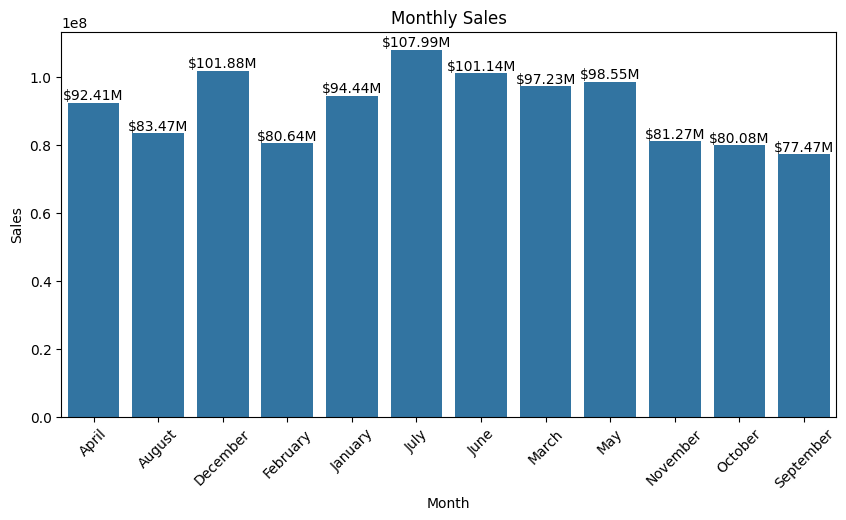

In [ ]:
df_merge["month"] = df_merge["date"].dt.month_name()

# Group sales by month
monthly_sales_df = df_merge.groupby("month")["sales"].sum().sort_index()

# Set figure size
plt.figure(figsize = (10, 5))

# Plot line chart for sales by year
sns.barplot(x = monthly_sales_df.index, y = monthly_sales_df.values)

# Set the title and labels
plt.title("Monthly Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.tick_params(axis = "x", labelrotation = 45)

# Annotate bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    width = bar.get_width()
    x, y = bar.get_xy()
    plt.annotate(f"${height/10**6:,.2f}M", (x + width/2, y + height*1.01), ha = "center")

plt.show()

### Key Insights
1. **Quarterly sales**
- Higher sales in Q2 might indicate a seasonal trend where consumers spend more during this period, possibly due to holidays or mid-year bonuses.
- The dip in Q3 and Q4 suggests these quarters might face reduced consumer spending, which could be due to back-to-school expenses in Q3 and the post-holiday spending dip in Q4.
2. **Monthly sales**
- July’s peak could be influenced by mid-year sales, summer holidays, or special promotions.
- Low sales months like September and February could be due to these months typically being periods of reduced consumer spending after significant spending periods (e.g., back-to-school in September and post-holiday season in February).
- August and October might also reflect post-summer and pre-holiday spending slumps

8. Which product family and stores did the promotions affect.

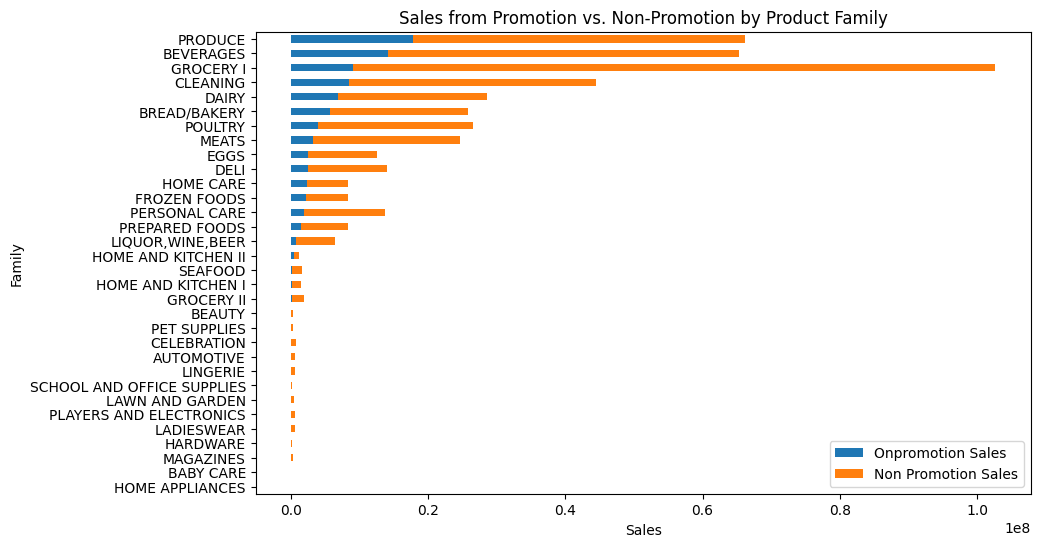

In [ ]:
# Filter dataset by promotion status
promotion_df = df_merge[df_merge["onpromotion"] == 1]
not_onpromotion_df = df_merge[df_merge["onpromotion"] == 0]

# Group promotion and non-promotion data by product family
promotion_sales_by_family = promotion_df.groupby("family")["sales"].sum().sort_values(ascending=True).rename("Onpromotion Sales").reset_index()
not_promotion_sales_by_family = not_onpromotion_df.groupby("family")["sales"].sum().rename("Non Promotion Sales").reset_index()

# Merge the two dataframes on the 'family' column, keeping all product families
combined_df = promotion_sales_by_family.merge(not_promotion_sales_by_family, on="family", how="left")

# Set the 'family' column as the index and create a horizontal stacked bar plot
combined_df.set_index("family").plot(kind="barh", stacked=True, figsize=(10, 6))

# Add title and labels to the plot
plt.title("Sales from Promotion vs. Non-Promotion by Product Family")
plt.xlabel("Sales")
plt.ylabel("Family")

# Show the plot
plt.show()

9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

- Mean Absolute Error (MAE)<br>

Definition: The average of the absolute differences between predicted and actual values.<br>
Characteristics:<br>
MAE is straightforward to interpret as it represents the average absolute error.
It is less sensitive to outliers compared to MSE and RMSE since it does not square the errors.

- Mean Squared Error (MSE)<br>

Definition: The average of the squared differences between predicted and actual values.<br>
Characteristics:<br>
MSE gives more weight to larger errors due to squaring the differences.
It can be more useful when large errors are particularly undesirable.
However, it is harder to interpret since it is in squared units of the target variable.

- Root Mean Squared Error (RMSE)<br>

Definition: The square root of the average of the squared differences between predicted and actual values.<br>
Characteristics:<br>
RMSE is in the same units as the target variable, making it easier to interpret compared to MSE.
Like MSE, RMSE is more sensitive to outliers due to the squaring of errors.

- Root Mean Squared Logarithmic Error (RMSLE)<br>

Definition: The square root of the average of the squared logarithmic differences between predicted and actual values.<br>
Characteristics:<br>
RMSLE penalizes underestimates more than overestimates.
It is useful when you care more about relative differences than absolute differences.
It is less sensitive to large errors compared to RMSE.

#### Why is MAE Greater Than RMSE, MSE, and RMSLE?<br>

**Sensitivity to Large Errors:**<br>
RMSE and MSE are more sensitive to large errors due to the squaring of the differences. This means that a few large errors will disproportionately increase these metrics compared to MAE.
MAE measures the average error in a linear way, so it does not exaggerate the impact of large errors.

**Units and Interpretation:**<br>
RMSE and MSE can be smaller than MAE if there are significant outliers or large errors because squaring the differences spreads the impact of large errors over the entire dataset.
RMSLE can be smaller than MAE if the dataset has a lot of variation in scale, as it measures the relative difference rather than absolute differences.

**Logarithmic Differences:**<br>
RMSLE uses logarithmic differences, which can reduce the impact of large values and make the errors appear smaller, especially when dealing with exponential growth or when values vary over a large range.
In summary, MAE might be greater than RMSE, MSE, and RMSLE because it does not square the errors, thus not exaggerating the impact of large errors, while the other metrics, especially RMSE and MSE, can show smaller values in the presence of large errors due to the squaring effect. RMSLE's use of logarithmic differences also tends to dampen the impact of large differences, making it potentially smaller than MAE.

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

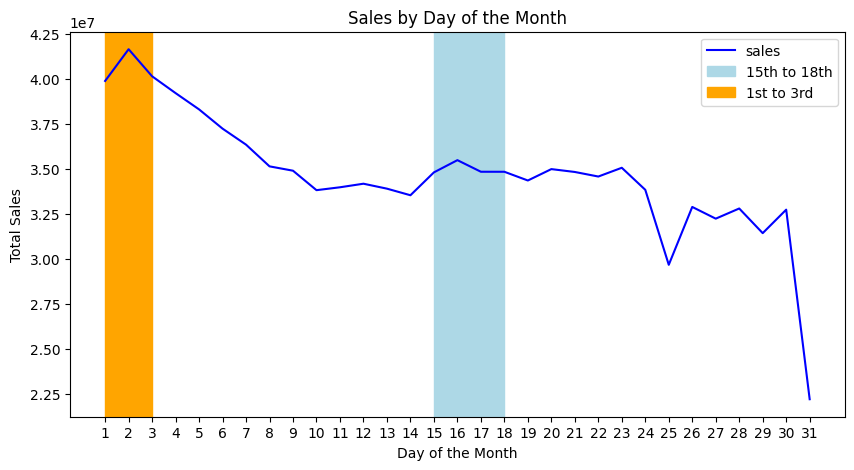

In [ ]:
# Sales by day of the month
df_train["day_of_month"] = df_train["date"].dt.day
sales_by_day_month = df_train.groupby("day_of_month")["sales"].sum()
sales_by_day_month.plot(kind = "line", figsize=(10, 5), xlabel = "Day of the Month", ylabel = "Total Sales", title = "Sales by Day of the Month", color= "blue")

# Highlight different periods
plt.axvspan(15, 18, color = "lightblue", label = "15th to 18th")
plt.axvspan(1, 3, color = "orange", label = "1st to 3rd")

plt.xticks(range(1, 32), rotation = "horizontal")
plt.legend(loc = "upper right")
plt.show()

### Key Insights
The data suggests that the payment of wages in the public sector on the 1st and 15th of the month has a significant influence on store sales. Sales increase notably around these dates, indicating that consumers tend to spend more immediately after receiving their wages. This pattern is followed by a decline in sales as the month progresses, especially towards the end of the month.

### **DECOMPOSITION**

#### **implementation**

In [ ]:
# Define a function that is responsible for ploting the time series component individually
def decompose(df_merge, column_name):
    """
    Decompose a time series into trend, seasonality, and residual components using both multiplicative and additive models.

    Parameters:
        df (DataFrame): The input DataFrame containing time series data.
        column_name (str): The column name for which trend, seasonality, and residual are to be captured.

    Returns:
        result_mul (seasonal_decompose): Result of the multiplicative decomposition.
        result_add (seasonal_decompose): Result of the additive decomposition.
    """
    # Perform multiplicative decomposition
    result_mul = seasonal_decompose(df_merge.groupby(df_merge['date'])[column_name].sum(), model='multiplicative', extrapolate_trend='freq', period=12)
    
    # Perform additive decomposition
    result_add = seasonal_decompose(df_merge.groupby(df_merge['date'])[column_name].sum(), model='additive', extrapolate_trend='freq', period=12)

    # Set plot size and create subplots
    plt.rcParams.update({'figure.figsize': (18, 10)})
    fig, ax = plt.subplots(4, 2)  # 4 rows, 2 columns for two sets of plots

    # Plot multiplicative decomposition
    result_mul.observed.plot(ax=ax[0, 0])
    result_mul.trend.plot(ax=ax[1, 0])
    result_mul.seasonal.plot(ax=ax[2, 0])
    ax[3, 0].scatter(result_mul.resid.index, result_mul.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Plot additive decomposition
    result_add.observed.plot(ax=ax[0, 1])
    result_add.trend.plot(ax=ax[1, 1])
    result_add.seasonal.plot(ax=ax[2, 1])
    ax[3, 1].scatter(result_add.resid.index, result_add.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Set suptitles
    ax[0, 0].set_title('Multiplicative Decompose - Observed')
    ax[0, 1].set_title('Additive Decompose - Observed')
    
    ax[1, 0].set_title('Multiplicative Decompose - Trend')
    ax[1, 1].set_title('Additive Decompose - Trend')
    
    ax[2, 0].set_title('Multiplicative Decompose - Seasonal')
    ax[2, 1].set_title('Additive Decompose - Seasonal')
    
    ax[3, 0].set_title('Multiplicative Decompose - Residual')
    ax[3, 1].set_title('Additive Decompose - Residual')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plots
    plt.show()

    return result_mul, result_add



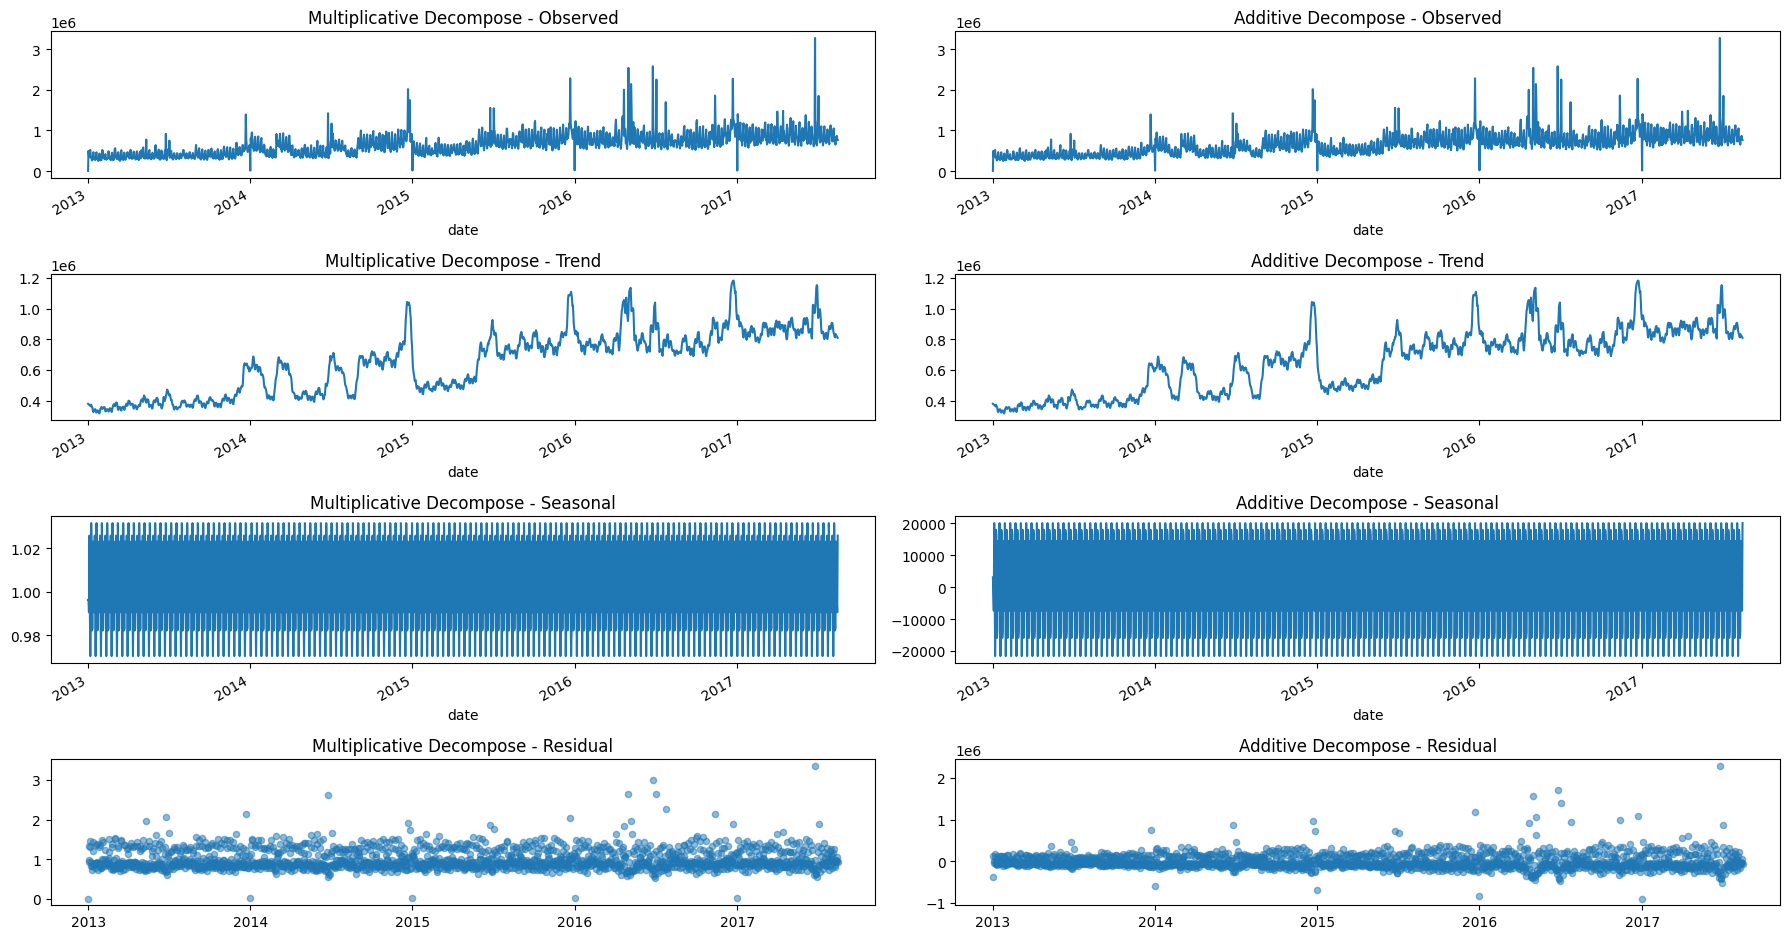

In [ ]:
# Generate the various plot by calling the decompose function
result_mul, result_add = decompose(df_merge, 'sales')

In [ ]:
# Concatenate the components into a DataFrame
decomposition_df = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)

# Assign column names
decomposition_df.columns = ['seasonal', 'trend', 'residual', 'actual_values']

# View the first 5 rows
decomposition_df.head()

,seasonal,trend,residual,actual_values
date,,,,
2013-01-01,3082.119445,379205.325329,-379775.825775,2511.618999
2013-01-02,-2277.808142,376372.271319,121997.954767,496092.417944
2013-01-03,-7361.480961,373539.217310,-4716.505225,361461.231124
2013-01-04,20101.434253,370706.163301,-36347.920461,354459.677093
2013-01-05,-2760.238610,367873.109292,112237.250547,477350.121229


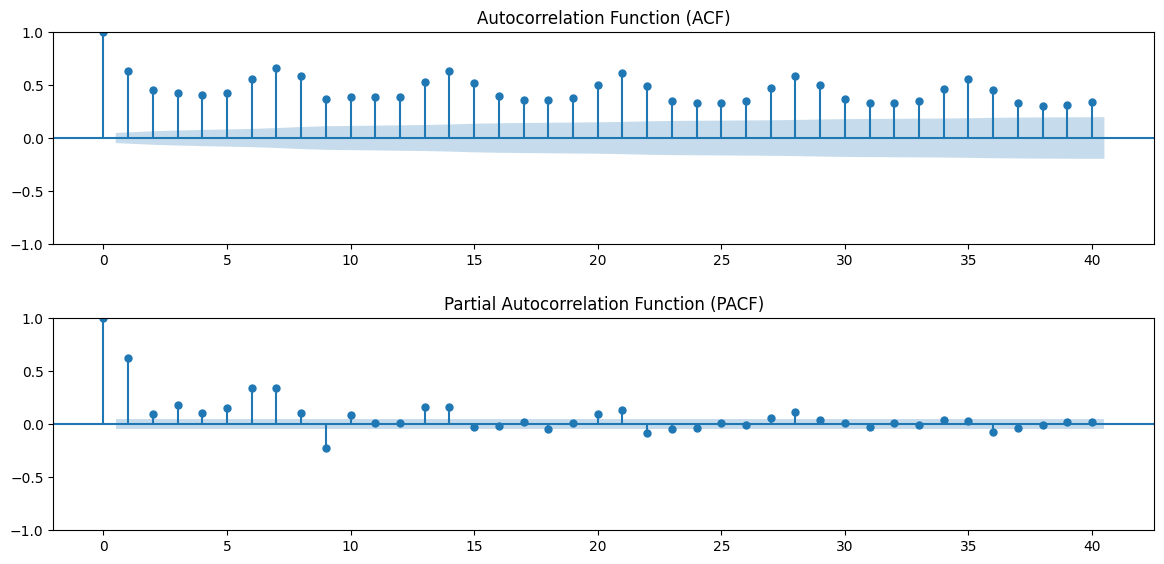

In [ ]:
# Get the sales time series data based on the sample
ts = df_merge.groupby(df_merge['date'])['sales'].sum()

# Create subplots with 2 rows and 1 column, specifying figsize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the Autocorrelation Function (ACF) on the first subplot (ax1)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")  # Add a title to the first subplot

# Plot the Partial Autocorrelation Function (PACF) on the second subplot (ax2)
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")  # Add a title to the second subplot

# Add padding between the two subplots for better visualization
plt.tight_layout(pad=2.0)

# Display the plots
plt.show()

Plot Interpretation:
The x-axis represents the lag, which is the number of time steps back from the current time step.
The y-axis represents the correlation coefficient, ranging from -1 to 1.
The blue shaded area represents the confidence interval. If a lag's bar crosses this area, the correlation is statistically significant.

Plot Insights:

The ACF plot shows a significant spike at lag 1, indicating that the first lag has a strong positive correlation with the current value.
Subsequent lags (2, 3, etc.) show decreasing correlation, which is typical for many time series.
There are some smaller significant spikes indicating lesser but still notable correlations at those lags.

Partial Autocorrelation Function (PACF)

Plot Interpretation:
The x-axis represents the lag.
The y-axis represents the partial correlation coefficient.
The blue shaded area represents the confidence interval. If a lag's bar crosses this area, the partial correlation is statistically significant.
Plot Insights:

The PACF plot shows a significant spike at lag 1, suggesting that the primary relationship is with the immediate past value.
Subsequent lags have smaller and mostly insignificant spikes, indicating that once the first lag is accounted for, the remaining lags do not add much additional information.

#### **STATIONARITY TEST (KPSS TEST)**
In time series analysis, performing a stationarity test is essential to determine whether the data remains consistent over time. For this project, I will utilize the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test to assess the stationarity of the data. This test specifically checks for the presence of a unit root, helping us identify if the time series has a constant mean and variance over time. Establishing stationarity is crucial as it influences the choice of models and the reliability of forecasts derived from the data.

In [ ]:
stats,p,lags,critical_values = kpss(df_merge['sales'],'ct')

print(f"Stats: {stats}\n")
print(f"P-Value: {p}\n")
print(f"Lags: {lags}\n")
print(f"Critical Values: {critical_values}\n")

if p< 0.05:
    print('The data is not stationary')
else:
    print('The dataset is stationary')

Stats: 1.1447155909908968

P-Value: 0.01

Lags: 644

Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

The data is not stationary


DATA DIFFENCING

In [ ]:
sales_data = df_merge['sales']

# Apply a logarithmic transformation (natural logarithm)
log_sales_data = np.log1p(sales_data)  # Using np.log1p to handle zero values safely

# Replace the 'sales' column with the transformed data in the DataFrame
df_merge['sales'] = log_sales_data

# Perform first-order differencing
first_order_diff = df_merge['sales'].diff(periods=1).dropna()

# Perform KPSS test on the differenced data
kpss_result = sm.tsa.kpss(first_order_diff)

# Extract KPSS test results for differenced data
kpss_statistic, p_value, lags, critical_values = kpss_result

# Print results
print(f'KPSS Statistic (Differenced Data): {kpss_statistic}')
print(f'p-value (Differenced Data): {p_value}')
print(f'Number of Lags Used (Differenced Data): {lags}')
print(f'Critical Values (Differenced Data): {critical_values}')

# Check if the differenced data is stationary
if p_value > 0.05:
    print('The differenced data is stationary. You can proceed with modeling.')
else:
    print('The differenced data is not stationary.')

KPSS Statistic (Differenced Data): 9.885417920644099e-05
p-value (Differenced Data): 0.1
Number of Lags Used (Differenced Data): 467
Critical Values (Differenced Data): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The differenced data is stationary. You can proceed with modeling.


Feature Engineering and Modelling

In [ ]:
# Rearrange columns to make 'sales' the last column
cols = [col for col in df_merge.columns if col != 'sales'] + ['sales']
df_merge= df_merge[cols]

# Aggregating data
df_family_aggregated = df_merge.groupby(['date', 'family']).agg({ 'sales': 'sum', 'onpromotion': 'sum' }).reset_index()

In [ ]:
#  Create day of the week feature
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# Lag sales by 1 to get the previous day sales value
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# Add rolling mean with a 7-day window 
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=7).mean()

In [ ]:

df_family_aggregated.isnull().sum()

date            0
family          0
sales           0
onpromotion     0
day_of_week     0
lag_1           1
rolling_mean    6
dtype: int64

### **DATA PREPROCESSING**

In [ ]:
# Define a high-level function to preprocess the data
def preprocess_data(df: pd.DataFrame):
    # Separate Categorial and Numerical Columns
    cat_col = df.select_dtypes('object').columns
    num_col = df.select_dtypes('number').columns

    # Save a copy of the date column
    original_date = df['date'].copy()

    # Define the preprocessing steps using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer([
        ('scaler', MinMaxScaler(), num_col),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_col),
    ], remainder='passthrough')

    # Fit the preprocessor to the data while the date is dropped
    preprocessor.fit(df.drop('date', axis=1))

    # Transform the data to get the preprocessed data
    preprocessed = preprocessor.transform(df.drop('date', axis=1)) # Get the various transformers
    encoder = preprocessor.named_transformers_['encoder']
    scaler = preprocessor.named_transformers_['scaler']

    # Access the feature names using the get_feature_names_out() method
    encoded_feature_names = encoder.get_feature_names_out(input_features=cat_col)
    scaled_feature_names = scaler.get_feature_names_out(input_features=num_col)

    # Form a list of all features
    all_feature_names = list(scaled_feature_names) + list(encoded_feature_names) 

    # Create a DataFrame and add the column names
    preprocessed_df = pd.DataFrame(preprocessed, columns=all_feature_names)

    # Set the index of the DataFrame to the original date
    preprocessed_df.index = original_date

    # Sort the DataFrame by date
    preprocessed_df = preprocessed_df.sort_index().reset_index()

    # Return the preprocessed data and the preprocessor
    return preprocessed_df, preprocessor


In [ ]:
df_family_aggregated.head()

,date,family,sales,onpromotion,day_of_week,lag_1,rolling_mean
0,2013-01-01,AUTOMOTIVE,0.000000,0,1,NaN,NaN
1,2013-01-01,BABY CARE,0.000000,0,1,0.000000,NaN
2,2013-01-01,BEAUTY,1.098612,0,1,0.000000,NaN
3,2013-01-01,BEVERAGES,6.698268,0,1,1.098612,NaN
4,2013-01-01,BOOKS,0.000000,0,1,6.698268,NaN


In [ ]:
train_size = int(0.8 * len(df_merge))
train_data = df_merge[:train_size]
test_data = df_merge[train_size:]

In [ ]:
# shapes
df_merge.shape, test_data.shape

((3054348, 17), (610870, 17))

In [ ]:

df_merge = df_merge.reset_index()
X_train = df_merge.drop(columns=['sales', 'date'])
y_train = df_merge['sales']


In [ ]:

X_test = df_merge.drop(columns=['sales', 'date'])
y_test = df_merge['sales']

#### **MODELING**
For the modeling, 4 models will be trained and evaluated using the 20% test set and the best performing model will be considered for hyperparameter tuning and future predictions. These are:

- ARIMA (AutoRegressive Integrated Moving Average): ARIMA is a time series forecasting model that combines autoregressive (AR) and moving average (MA) components to make predictions. It is suitable for univariate time series data and can capture trends and seasonality in the data. ARIMA requires the data to be stationary.

- SARIMA (Seasonal AutoRegressive Integrated Moving Average): SARIMA is an extension of the ARIMA model that takes into account seasonal patterns in time series data. It includes seasonal AR and MA terms to capture recurring patterns over time. SARIMA is useful for this analysis since the data exhibits seasonal trends.

- Exponential Smoothing: Exponential smoothing is a time series forecasting method that assigns exponentially decreasing weights to past observations. Exponential smoothing methods include simple exponential smoothing, Holt's linear exponential smoothing, and Holt-Winters exponential smoothing, which handles seasonality.

- XGBoost (Extreme Gradient Boosting): XGBoost is a powerful ensemble learning algorithm that builds an ensemble of decision trees and optimizes their weights to make accurate predictions. It often performs well in predictive modeling tasks such as time series forcsting.

In [ ]:
# Define a custom color palette
custom_color_palette = ["#835AF1", "#37AA9C", "#B8F7D4", "#94F3E4"]

# Define a function to plot the predictions aganist the actuals
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Set the custom color palette
    sns.set_palette(custom_color_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(x=date, y=y_test, label='Actual', color=custom_color_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(x=date, y=y_pred, label=forecast_label, color=custom_color_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

In [ ]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [ ]:
# Exogenous variables to help predict sales
ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']

#### Baseline

In [ ]:
# X_train, X_test, y_train, y_test= train_test_split(df_merge[['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']], df_merge["sales"], test_size= 0.2, random_state=42)
# # Baseline model
# y_pred_baseline= np.full(len((y_test),), y_train.mean())
# mse_baseline= mean_squared_error(y_test, y_pred_baseline)
# rmse_baseline= np.sqrt(mse_baseline)
# mae_baseline= mean_absolute_error(y_test, y_pred_baseline)
# mape_baseline= np.mean(np.abs((y_test-y_pred_baseline)/y_test))*100
# r2_baseline= r2_score (y_test, y_pred_baseline)

# print("Baseline Model")
# print(f"MSE:{mse_baseline: .2f}")
# print(f"RMSE:{rmse_baseline: .2f}")
# print(f"MAE:{mae_baseline: .2f}")
# print(f"MAPE:{mape_baseline: .2f}")
# print(f"R2:{r2_baseline: .2f}")

#### **ARIMA MODEL**

In [ ]:
ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']


In [ ]:
# Define Instance of the Model
model_arima = sm.tsa.ARIMA(y_train, exog=X_train[ex_variables], order=(1,0,0))

# Fit the Model
results_arima = model_arima.fit()

# Make Predictions
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

KeyError: "['day_of_week', 'lag_1', 'rolling_mean'] not in index"